# Homework 5: Networks and Congress

*Due Friday, November 15, 11:59pm*

<img src="http://img.washingtonpost.com/rf/image_1024w/2010-2019/WashingtonPost/2011/08/05/National-Politics/Images/uscap.JPG">

<br>

In [3]:
%matplotlib inline

import json

import numpy as np
import networkx as nx
import requests
from pattern import web
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

The website [govtrack.us](http://www.govetrack.us) collects data on activities in the Senate and House of Representatives. It's a great source of information for making data-driven assessments about Congress.

### Problem 1.

The directories at http://www.govtrack.us/data/congress/113/votes/2013 contain JSON information about every vote cast for the current (113th)  Congress. Subdirectories beginning with "S" correspond to Senate votes, while subdirectories beginning with "H" correspond to House votes.

Write two functions: one that downloads and parses a single Senate vote page given the vote number, and another that repeatedly calls this function to build a full collection of Senate votes from the 113th Congress.

In [4]:
"""
Function
--------
get_senate_vote

Scrapes a single JSON page for a particular Senate vote, given by the vote number

Parameters
----------
vote : int
   The vote number to fetch
   
Returns
-------
vote : dict
   The JSON-decoded dictionary for that vote
   
Examples
--------
>>> get_senate_vote(11)['bill']
{u'congress': 113,
 u'number': 325,
 u'title': u'A bill to ensure the complete and timely payment of the obligations of the United States Government until May 19, 2013, and for other purposes.',
 u'type': u'hr'}
"""
#your code here
def get_senate_vote(vote):
    url_base = 'http://www.govtrack.us/data/congress/113/votes/2013/'
    url = url_base + 's' + str(vote) + '/data.json'
    return requests.get(url).json()
    

In [7]:
"""
Function
--------
get_all_votes

Scrapes all the Senate votes from http://www.govtrack.us/data/congress/113/votes/2013,
and returns a list of dicts

Parameters
-----------
None

Returns
--------
votes : list of dicts
    List of JSON-parsed dicts for each senate vote
"""
#Your code here
import re
def get_all_votes():
    votes = []
    url = 'http://www.govtrack.us/data/congress/113/votes/2013'
    reg = requests.get(url)
    elements = web.Element(req.text).by_tag('a')
    for e in elements:
        match = re.match('s(\d+)', e.content)
        if match:
            votes.append(get_senate_vote(int(match.group(1))))
    return votes

In [8]:
vote_data = get_all_votes()

In [38]:
len(vote_data)

291

### Problem 2

Now, turn these data into a NetworkX graph, according to the spec below. For details on using NetworkX, consult the lab materials for November 1, as well as the [NetworkX documentation](http://networkx.github.io/).

In [120]:
names = set()
for v in vote_data:
    for k in v['votes'].keys():
        for p in v['votes'][k]:
            names.add(p['display_name'])

len(names)

104

In [121]:
weight = {n1: {n2: 0 for n2 in names if n1 != n2} for n1 in names}

In [122]:
for v in vote_data:
    for k in ('Yea', 'Nay'):
        for p in v['votes'][k]:
            for q in v['votes'][k]:
                if p['display_name']!=q['display_name']:
                    weight[p['display_name']][q['display_name']] += 1

In [126]:
for n1 in weight.keys():
    for n2 in weight[n1].keys():
        if weight[n1][n2] != 0:
            g.add_edge(n1, n2)
            g[n1][n2]['weight'] = weight[n1][n2]
            g[n1][n2]['difference'] = 1./g[n1][n2]['weight']

In [127]:
g['Lee (R-UT)']['Baldwin (D-WI)']
    

{'difference': 0.017543859649122806, 'weight': 57}

In [128]:
"""
Function
--------
vote_graph

Parameters
----------
data : list of dicts
    The vote database returned from get_vote_data

Returns
-------
graph : NetworkX Graph object, with the following properties
    1. Each node in the graph is labeled using the `display_name` of a Senator (e.g., 'Lee (R-UT)')
    2. Each node has a `color` attribute set to 'r' for Republicans, 
       'b' for Democrats, and 'k' for Independent/other parties.
    3. The edges between two nodes are weighted by the number of 
       times two senators have cast the same Yea or Nay vote
    4. Each edge also has a `difference` attribute, which is set to `1 / weight`.

Examples
--------
>>> graph = vote_graph(vote_data)
>>> graph.node['Lee (R-UT)']
{'color': 'r'}  # attributes for this senator
>>> len(graph['Lee (R-UT)']) # connections to other senators
101
>>> graph['Lee (R-UT)']['Baldwin (D-WI)']  # edge relationship between Lee and Baldwin
{'difference': 0.02, 'weight': 50}
"""
#Your code herei
def vote_graph(data):
    # set up all nodes
    names = set()
    for v in data:
        for p in v['votes'].values()[0]:
            names.add(p['display_name'])
    g = nx.Graph()
    
    for n in list(names):
        g.add_node(n)
        m = re.search('([R|D|I])-', n)
        if m:
            if m.group(1) == 'R':
                g.node[n]['color'] = 'r'
            if m.group(1) == 'D':
                g.node[n]['color'] = 'b'
            if m.group(1) == 'I':
                g.node[n]['color'] = 'k'
    # loop through all the votes to set up edge
    weight = {n1: {n2: 0 for n2 in names if n1 != n2} for n1 in names}
    for v in data:
        for k in ('Yea', 'Nay'):
            for p in v['votes'][k]:
                for q in v['votes'][k]:
                    if p['display_name']!=q['display_name']:
                        weight[p['display_name']][q['display_name']] += 1            
   
    # graph edge has no direction, so doesn't need to have both weight[n1][n2] and weight[n2][n1]
    for n1 in weight.keys():
        for n2 in weight[n1].keys():
            if weight[n1][n2] != 0:
                g.add_edge(n1, n2)
                g[n1][n2]['weight'] = weight[n1][n2]
                g[n1][n2]['difference'] = 1./g[n1][n2]['weight']


    return g

In [131]:
votes['Baldwin (D-WI)']['Lee (R-UT)']

{'difference': 0.017543859649122806, 'weight': 57}

In [129]:

votes = vote_graph(vote_data)    

### How (and how not) to visualize networks

Network plots often *look* impressive, but creating sensible network plots is tricky. From Ben Fry, the author of the Processing program:
<blockquote>
Usually a graph layout isn’t the best option for data sets larger than a few dozen nodes. You’re most likely to wind up with enormous spider webs or balls of string, and the mess seen so far is more often the case than not. Graphs can be a powerful way to represent relationships between data, but they are also a very abstract concept, which means that they run the danger of meaning something only to the creator of the graph. Often, simply showing the structure of the data says very little about what it actually means, even though it’s a perfectly accurate means of representing the data. Everything looks like a graph, but almost nothing should ever be drawn as one.
</blockquote>

Let's look at bad and better ways of visualizing the senate vote network.

First, consider the "default" plot from networkx.

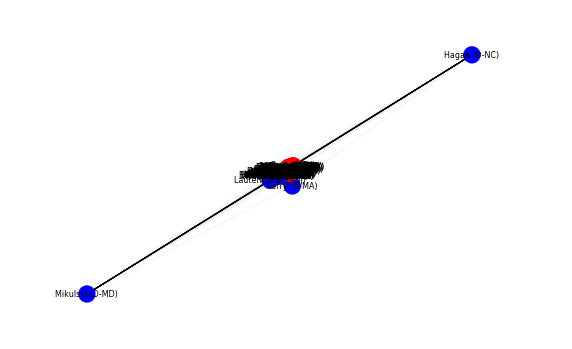

In [132]:
#this makes sure draw_spring results are the same at each call
np.random.seed(1)  

color = [votes.node[senator]['color'] for senator in votes.nodes()]

#determine position of each node using a spring layout
pos = nx.spring_layout(votes, iterations=200)

#plot the edges
nx.draw_networkx_edges(votes, pos, alpha = .05)

#plot the nodes
nx.draw_networkx_nodes(votes, pos, node_color=color)

#draw the labels
lbls = nx.draw_networkx_labels(votes, pos, alpha=5, font_size=8)

#coordinate information is meaningless here, so let's remove it
plt.xticks([])
plt.yticks([])
remove_border(left=False, bottom=False)

The spring layout tries to group nodes with large edge-weights near to each other. In this context, that means it tries to organize the Senate into similarly-voting cliques. However, there's simply too much going on in this plot -- we should simplify the representation.

### Problem 3

Compute the `Minimum Spanning Tree` of this graph, using the `difference` edge attribute as the weight to minimize. A [Minimum Spanning Tree](http://en.wikipedia.org/wiki/Minimum_spanning_tree) is the subset of edges which trace at least one path through all nodes ("spanning"), with minimum total edge weight. You can think of it as a simplification of a network.

Plot this new network, making modifications as necessary to prevent the graph from becoming too busy.

In [154]:
len(list(votes.nodes()))

104

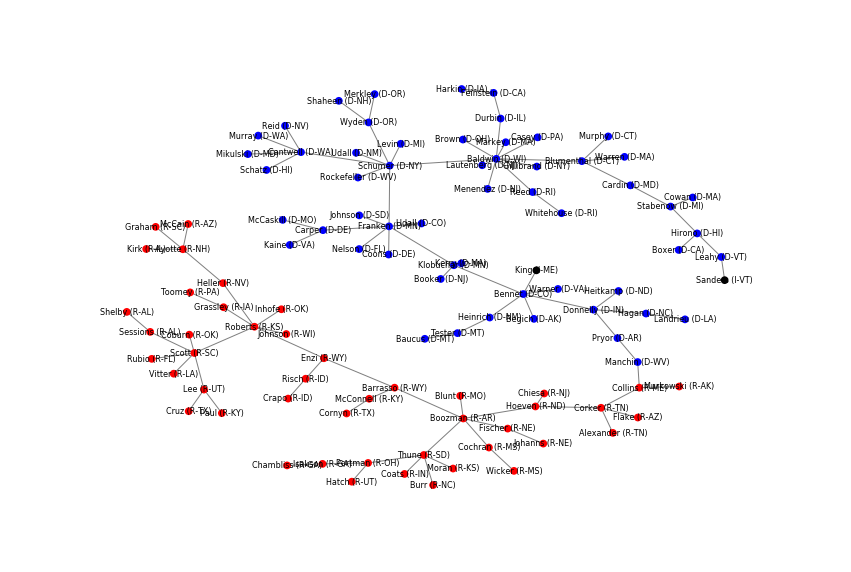

In [159]:
#Your code here
plt.figure(figsize=(15, 10))
np.random.seed(5)
weight = 'difference'
minTree = nx.minimum_spanning_tree(votes, weight)
minEdge = list(nx.minimum_spanning_edges(votes, weight))
np.random.seed(1)  

color = [votes.node[senator]['color'] for senator in votes.nodes()]

#determine position of each node using a spring layout
pos = nx.spring_layout(minTree, k = 0.008, weight = weight, iterations=900)

#plot the edges
nx.draw_networkx_edges(votes, pos, edgelist = minEdge, alpha = .5, color='r')

#plot the nodes
nx.draw_networkx_nodes(votes, pos, node_color=color, node_size=60)

#draw the labels
lbls = nx.draw_networkx_labels(votes, pos, alpha=5, font_size=8)

#coordinate information is meaningless here, so let's remove it
plt.xticks([])
plt.yticks([])
remove_border(left=False, bottom=False)

### Problem 4

While this graph has less information, the remaining information is easier to digest. What does the Minimum Spanning Tree mean in this context? How does this graph relate to partisanship in the Senate? Which nodes in this graph are the most and least bi-partisan?

*Your answer here*

### Problem 5

(For this problem, use the full graph for centrality computation, and not the Minimum Spanning Tree)

Networkx can easily compute [centrality](https://en.wikipedia.org/wiki/Centrality) measurements. 

Briefly discuss what ``closeness_centrality`` means, both mathematically and in the context of the present graph -- how does the centrality relate to partisanship? Choose a way to visualize the `closeness_centrality` score for each member of the Senate, using edge `difference` as the distance measurement. Determine the 5 Senators with the highest and lowest centralities. 

Comment on your results. In particular, note the outliers John Kerry (who recently resigned his Senate seat when he became Secretary of State), Mo Cowan (Kerry's interim replacement) and Ed Markey (Kerry's permanent replacement) have low centrality scores -- why?

*Your discussion here*

In [197]:
#Your code here
import operator
closeness_centrality = nx.closeness_centrality(votes, distance = 'difference')
#cc = [closeness_centrality[p] for p in closeness_centrality.keys()]
cc_sorted = sorted(closeness_centrality.iteritems(), key=operator.itemgetter(1))

In [202]:
print "the 5 senators with the lowest centralities:"
for (k, v) in cc_sorted[:5]:
    print k, v

the 5 senators with the lowest centralities:
Kerry (D-MA) 3.96243365083
Lautenberg (D-NJ) 26.1731143265
Chiesa (R-NJ) 41.5795648441
Booker (D-NJ) 44.0662771025
Markey (D-MA) 64.721637717


In [201]:
print "the 5 senators with the highest centralities:"
for (k, v) in cc_sorted[-5:]:
    print k, v

the 5 senators with the highest centralities:
Donnelly (D-IN) 109.468958317
Murkowski (R-AK) 111.100360195
Pryor (D-AR) 111.204369285
Manchin (D-WV) 112.650034408
Collins (R-ME) 117.854891195


<Container object of 104 artists>

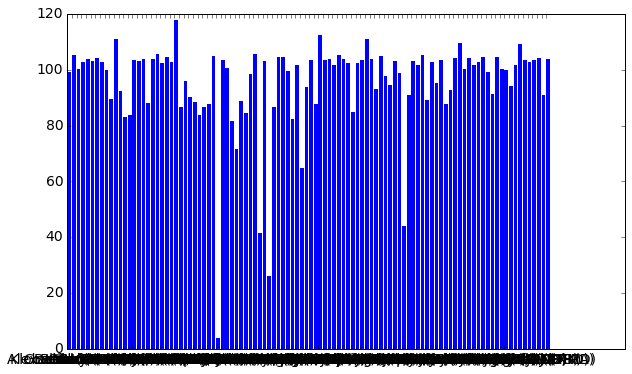

In [173]:
plt.bar(left = range(len(cc)), height=cc, tick_label = closeness_centrality.keys())

### Problem 6

Centrality isn't a perfect proxy for bipartisanship, since it gauges how centralized a node is to the network as a whole, and not how similar a Democrat node is to the Republican sub-network (and vice versa).

Can you come up with another measure that better captures bipartisanship than closeness centrality? Develop your own metric -- how does it differ from the closeness centrality? Use visualizations to support your points.

In [221]:
other = []
for (n, e) in votes['Alexander (R-TN)'].items():
    if votes.node['Alexander (R-TN)']['color'] != votes.node[n]['color']:
        other.append(e['weight'])
np.mean(other)

106.0

In [215]:
votes.node['Alexander (R-TN)']

{'color': 'r'}

In [226]:
#your code here
def if_other_party(color1, color2):
    if color1 == 'r':
        return color2 == 'b' or color2 == 'k'
    else:
        return color2 == 'r'
    
bp_score = {}
for s in votes:
    bp_score[s] = (np.mean([e['weight'] for (n, e) in votes[s].items() if if_other_party(votes.node[s]['color'], 
                                                                                 votes.node[n]['color']) ]
                        ))
# sort bp_score
sorted_bp_score = sorted(bp_score.iteritems(), key=operator.itemgetter(1))
sorted_bp_score

[(u'Kerry (D-MA)', 2.2352941176470589),
 (u'Lautenberg (D-NJ)', 9.2888888888888896),
 (u'Booker (D-NJ)', 10.022222222222222),
 (u'Markey (D-MA)', 30.369565217391305),
 (u'Chiesa (R-NJ)', 39.072727272727271),
 (u'Cowan (D-MA)', 50.391304347826086),
 (u'Inhofe (R-OK)', 53.517241379310342),
 (u'Cruz (R-TX)', 55.877192982456137),
 (u'Risch (R-ID)', 57.051724137931032),
 (u'Lee (R-UT)', 57.438596491228068),
 (u'Vitter (R-LA)', 57.672413793103445),
 (u'Scott (R-SC)', 60.666666666666664),
 (u'Paul (R-KY)', 61.526315789473685),
 (u'Coburn (R-OK)', 61.859649122807021),
 (u'Crapo (R-ID)', 65.465517241379317),
 (u'Roberts (R-KS)', 65.91379310344827),
 (u'Enzi (R-WY)', 66.534482758620683),
 (u'Barrasso (R-WY)', 67.965517241379317),
 (u'Cornyn (R-TX)', 69.741379310344826),
 (u'Johnson (R-WI)', 69.912280701754383),
 (u'Sessions (R-AL)', 70.421052631578945),
 (u'Rubio (R-FL)', 72.421052631578945),
 (u'Shelby (R-AL)', 76.41379310344827),
 (u'McConnell (R-KY)', 77.568965517241381),
 (u'Moran (R-KS)', 7


*Your discussion here*

## Leadership in the Senate

There are many metrics to quantify the leadership in the Senate.

  1. Senate leaders sponsor and co-sponsor lots of bills
  2. Leaders sit on many committees, as well as more important committees
  3. Leaders usually have been in office for a long time
  
Another approach uses the philosophy behind how Google ranks search results. The core idea behind Google's PageRank algorithm is:

1. A "good" website (i.e. one to rank highly in search results) is linked to by many other websites
2. A link found on a "good" website is more important than a link found on a "bad" website

The PageRank algorithm thus assigns scores to nodes in a graph based on how many neighbors a node has, as well as the score of those neighbors.

This technique can be adapted to rank Senate leadership. Here, nodes correspond to Senators, and edges correspond to a senator co-sponsoring a bill sponsored by another Senator. The weight of each edge from node A to B is the number of times Senator A has co-sponsored a bill whose primary sponsor is Senator B. If you interpret the PageRank scores of such a network to indicate Senate leadership, you are then assuming:

1. Leaders sponsor more bills
1. Leaders attract co-sponsorship from other leaders

### Problem 7

Govtrack stores information about each Senate bill in the current congress at http://www.govtrack.us/data/congress/113/bills/s/. As in problem 1, write two functions to scrape these data -- the first function downloads a single bill, and the second function calls the first to loop over all bills.

In [227]:
"""
Function
--------
get_senate_bill

Scrape the bill data from a single JSON page, given the bill number

Parameters
-----------
bill : int
   Bill number to fetch
   
Returns
-------
A dict, parsed from the JSON

Examples
--------
>>> bill = get_senate_bill(10)
>>> bill['sponsor']
{u'district': None,
 u'name': u'Reid, Harry',
 u'state': u'NV',
 u'thomas_id': u'00952',
 u'title': u'Sen',
 u'type': u'person'}
>>> bill['short_title']
u'Agriculture Reform, Food, and Jobs Act of 2013'
"""
#your code here
def get_senate_bill(bill):
    url = "https://www.govtrack.us/data/congress/113/bills/s/s" + str(bill) + "/data.json"
    req = requests.get(url)
    return req.json()

In [229]:
get_senate_bill(10)['sponsor']

{u'district': None,
 u'name': u'Reid, Harry',
 u'state': u'NV',
 u'thomas_id': u'00952',
 u'title': u'Sen',
 u'type': u'person'}

In [241]:
"""
Function
--------
get_all_bills

Scrape all Senate bills at http://www.govtrack.us/data/congress/113/bills/s

Parameters
----------
None

Returns
-------
A list of dicts, one for each bill
"""
#your code here
import time
def get_all_bills():
    # get html with all links
    bills = []
    req = requests.get("https://www.govtrack.us/data/congress/113/bills/s")
    html = req.text
    element = web.Element(html).by_tag('a')
    # loop through the links
    for e in element:
        match = re.search('s(\d+)', e.content)
        if match:
            bills.append(get_senate_bill(int(match.group(1))))
            time.sleep(0.1)
    return bills

In [242]:
bill_list = get_all_bills()

### Problem 8

Write a function to builded a Directed Graph (DiGraph) from these data, according to the following spec:

In [247]:
bill_list[0]['cosponsors']

[{u'district': None,
  u'name': u'Blumenthal, Richard',
  u'sponsored_at': u'2013-01-22',
  u'state': u'CT',
  u'thomas_id': u'02076',
  u'title': u'Sen',
  u'withdrawn_at': None},
 {u'district': None,
  u'name': u'Boxer, Barbara',
  u'sponsored_at': u'2013-01-22',
  u'state': u'CA',
  u'thomas_id': u'00116',
  u'title': u'Sen',
  u'withdrawn_at': None},
 {u'district': None,
  u'name': u'Brown, Sherrod',
  u'sponsored_at': u'2013-01-22',
  u'state': u'OH',
  u'thomas_id': u'00136',
  u'title': u'Sen',
  u'withdrawn_at': None},
 {u'district': None,
  u'name': u'Coons, Christopher A.',
  u'sponsored_at': u'2013-01-22',
  u'state': u'DE',
  u'thomas_id': u'01984',
  u'title': u'Sen',
  u'withdrawn_at': None},
 {u'district': None,
  u'name': u'Durbin, Richard',
  u'sponsored_at': u'2013-01-22',
  u'state': u'IL',
  u'thomas_id': u'00326',
  u'title': u'Sen',
  u'withdrawn_at': None},
 {u'district': None,
  u'name': u'Feinstein, Dianne',
  u'sponsored_at': u'2013-01-22',
  u'state': u'CA',


In [267]:
senators = set()
for b in bill_list:
    senators.add(b['sponsor']['name'])
    for s in b['cosponsors']:
        senators.add(s['name'])
len(senators)

105

In [268]:
d = {'a': 1, 'b': 2}
d['a']

1

In [283]:
for s1 in weight:
    for s2 in weight[s1]:
        g.add_edge(s1, s2, {'weight': weight[s1][s2]})
g.edge

{u'Alexander, Lamar': {u'Ayotte, Kelly': {'weight': 1},
  u'Baldwin, Tammy': {'weight': 0},
  u'Barrasso, John': {'weight': 3},
  u'Baucus, Max': {'weight': 1},
  u'Begich, Mark': {'weight': 0},
  u'Bennet, Michael F.': {'weight': 3},
  u'Blumenthal, Richard': {'weight': 1},
  u'Blunt, Roy': {'weight': 3},
  u'Booker, Cory A.': {'weight': 0},
  u'Boozman, John': {'weight': 1},
  u'Boxer, Barbara': {'weight': 0},
  u'Brown, Sherrod': {'weight': 2},
  u'Burr, Richard': {'weight': 1},
  u'Cantwell, Maria': {'weight': 2},
  u'Cardin, Benjamin L.': {'weight': 2},
  u'Carper, Thomas R.': {'weight': 0},
  u'Casey, Robert P., Jr.': {'weight': 5},
  u'Chambliss, Saxby': {'weight': 0},
  u'Chiesa, Jeff': {'weight': 0},
  u'Coats, Daniel': {'weight': 1},
  u'Coburn, Tom': {'weight': 4},
  u'Cochran, Thad': {'weight': 0},
  u'Collins, Susan M.': {'weight': 0},
  u'Coons, Christopher A.': {'weight': 1},
  u'Corker, Bob': {'weight': 2},
  u'Cornyn, John': {'weight': 2},
  u'Cowan, William M.': {'wei

In [297]:
"""
Function
--------
bill_graph

Turn the bill graph data into a NetworkX Digraph

Parameters
----------
data : list of dicts
    The data returned from get_all_bills

Returns
-------
graph : A NetworkX DiGraph, with the following properties
    * Each node is a senator. For a label, use the 'name' field 
      from the 'sponsor' and 'cosponsors' dict items
    * Each edge from A to B is assigned a weight equal to how many 
      bills are sponsored by B and co-sponsored by A
"""
#Your code here
def bill_graph(data):
    # get a list of senators
    senators = set()
    for b in data:
        senators.add(b['sponsor']['name'])
        for s in b['cosponsors']:
            senators.add(s['name'])
    
    # build weight hash
    weight = {s1: {s2: 0 for s2 in senators if s2 != s1} for s1 in senators}
    for b in data:
        for co in b['cosponsors']:
            weight[co['name']][b['sponsor']['name']] += 1
        
    # build graph
    g = nx.DiGraph()
    for s in senators:
        g.add_node(s)
    
    for s1 in weight.keys():
        for s2 in weight[s1].keys():
            g.add_edge(s1, s2, {'weight': weight[s1][s2]})
    return g

In [298]:
bills = bill_graph(bill_list)

In [300]:
bills['Johnson, Tim']

{u'Alexander, Lamar': {'weight': 0},
 u'Ayotte, Kelly': {'weight': 2},
 u'Baldwin, Tammy': {'weight': 0},
 u'Barrasso, John': {'weight': 1},
 u'Baucus, Max': {'weight': 5},
 u'Begich, Mark': {'weight': 4},
 u'Bennet, Michael F.': {'weight': 1},
 u'Blumenthal, Richard': {'weight': 1},
 u'Blunt, Roy': {'weight': 2},
 u'Booker, Cory A.': {'weight': 0},
 u'Boozman, John': {'weight': 0},
 u'Boxer, Barbara': {'weight': 4},
 u'Brown, Sherrod': {'weight': 7},
 u'Burr, Richard': {'weight': 0},
 u'Cantwell, Maria': {'weight': 4},
 u'Cardin, Benjamin L.': {'weight': 2},
 u'Carper, Thomas R.': {'weight': 0},
 u'Casey, Robert P., Jr.': {'weight': 4},
 u'Chambliss, Saxby': {'weight': 0},
 u'Chiesa, Jeff': {'weight': 0},
 u'Coats, Daniel': {'weight': 0},
 u'Coburn, Tom': {'weight': 0},
 u'Cochran, Thad': {'weight': 1},
 u'Collins, Susan M.': {'weight': 1},
 u'Coons, Christopher A.': {'weight': 1},
 u'Corker, Bob': {'weight': 0},
 u'Cornyn, John': {'weight': 0},
 u'Cowan, William M.': {'weight': 0},
 

### Problem 9

Using `nx.pagerank_numpy`, compute the PageRank score for each senator in this graph. Visualize the results. Determine the 5 Senators with the highest
PageRank scores. How effective is this approach at identifying leaders? How does the PageRank rating compare to the degree of each node?

Note: you can read about individual Senators by searching for them on the [govtrack website](https://www.govtrack.us/).

In [314]:
d = {'a': 2, 'b': -1, 'c': 5}
# d_sorted = sorted(d.iteritems(), key=operator.itemgetter(1))
d_sorted = sorted(d.iteritems(), key=lambda item: item[1])

d_sorted

[('b', -1), ('a', 2), ('c', 5)]

In [301]:
#Your code here
page_rank = nx.pagerank_numpy(bills)


105

In [305]:
page_rank_sort = sorted(page_rank.iteritems(), key=operator.itemgetter(1))

In [308]:
print "highest ranking senators:"
for s in page_rank_sort[-5:]:
    print s

highest ranking senators:
(u'Leahy, Patrick J.', 0.022087354743715263)
(u'Boxer, Barbara', 0.022546214288525903)
(u'Menendez, Robert', 0.026849989830274434)
(u'Harkin, Tom', 0.028110609673966808)
(u'Brown, Sherrod', 0.028198062836445905)


In [302]:
#Your code here


*Your discussion here*

### Interactive Visualization

Producing a good node link layout is not quite so simple. Nevertheless, we will give it a try. 

We will use [Gephi](https://gephi.org/) for interactive graph visualization. Gephi supports a wide variety of graph file formats, and NetworkX exports to several of them. We'll use the Graph Exchange XML Format (GEXF).

In [311]:
nx.write_gexf(votes, 'votes2.gexf')

### Problem 10: Analysis with Gephi

Download and install [Gephi](https://gephi.org/). See the [lab](http://goo.gl/SzHioP) for a brief introduction. Load the exported votes file. Try to produce a layout that clearly separates Democrats from Republicans (hint: filter on edge weight and re-layout once you filtered). Run PageRank and some other statistics and try encoding them with node color and node size. Run the "Modularity" statistic and encode the results in color.

Include a screenshot of your "best" visualization and embed the image here with `IPython.display.Image`. Make sure to include this image in your submission.

Explain your observations. Is the network visualization very helpful? Try to visualize your LinkedIn network (see the lab) or the one provided in the lab. Which dataset is more suitable for visualization and why is there a difference?


In [ ]:
from IPython.display import Image

path = 'name_of_your_screenshot'
Image(path)

*Your answer here*

### How to Submit

To submit your homework, create a folder named lastname_firstinitial_hw5 and place this notebook file in the folder. Double check that this file is still called HW5.ipynb, and that it contains your solutions. Also include any Gephi screenshots. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>